# Importing Libraries

In [135]:
import pandas as pd
import numpy as np
import datetime
from copy import copy

from kneed import KneeLocator
import plotly.express as px
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, PowerTransformer

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_precision_recall_curve

# Reading the Data

In [136]:
filename = 'D:/Ineuron/Project_workshop/Lead_Scoring_/Data/raw_data.csv'
data = pd.read_csv(filename, sep=';')

data.head().T

,0,1,2,3,4
age,56,57,37,40,56
job,housemaid,services,services,admin.,services
marital,married,married,married,married,married
education,basic.4y,high.school,high.school,basic.6y,high.school
default,no,unknown,no,no,no
housing,no,no,yes,no,no
loan,no,no,no,no,yes
contact,telephone,telephone,telephone,telephone,telephone
month,may,may,may,may,may
day_of_week,mon,mon,mon,mon,mon


In [137]:
a,b = train_test_split(data, test_size=0.25, stratify= data['y'])

In [138]:
b['y'].value_counts()

no     9137
yes    1160
Name: y, dtype: int64

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [140]:
data.duplicated().sum()

12

# Feature Engineering

### Droping unnecesary columns and duplicate rows

> As per the EDA we can drop `default`, `duration` and `pdays` columns

In [141]:
data = data.drop(columns=['default','pdays','duration'], axis='columns', )

data.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [142]:
#Let's see the shape of data

data.shape

(41188, 18)

> Finding the duplicate records

In [143]:
data.duplicated().sum()

2008

In [144]:
## There is total 2008 dupliacte records and I'm dropping them

data = data.drop_duplicates(keep='first')

data.shape

(39180, 18)

### Encoding Categorical values

> Creating a function which can rename classes in a column which has 5% or less frequency to a specified class

In [145]:
def reduce_class(data, columns, filter_by = 0.05, name_to_replace = 'other'):
    
    # Creatig a copy of dataframe
    temp_data = data
    
    for col in columns:  
        # Finding classes less than 5% of value_counts
        filter_ = temp_data[col].value_counts(normalize=True)> filter_by
        
        #saving the classe names below 5% value_count
        categories_to_replace = list(filter_[filter_==False].index)
        
        #Replcaing those classes with 'name_to_replace'
        temp_data[col] = np.where(temp_data[col].isin(categories_to_replace), name_to_replace, temp_data[col])
        #temp_data = temp_data[col].replace(categories_to_replace, name_to_replace)
        
    return temp_data    

In [146]:
## Applying the function on `data` and saving to `data` itself.

data = reduce_class(data, columns=['job', 'education', 'month'], name_to_replace = 'other')

In [147]:
## Replcaing 'campaign' column values of 5 or above with class name 'more_than_4'

data = reduce_class(data, ['campaign'], name_to_replace='more_than_4')

In [148]:
## Replcaing 'previous' column values of 2 or above with class name 'more_than_1'

data = reduce_class(data, ['previous'], name_to_replace='more_than_1')

In [149]:
data['previous'].value_counts()

0              33648
1               4476
more_than_1     1056
Name: previous, dtype: int64

### Equal_width_binning

- 'emp.var.rate' is actually a continous value in real world case, 
- even though in this data set it reflects as a categorical variable.
- 'emp.var.rate' 10 categories in this dataset

In [150]:
data['emp.var.rate'].value_counts()

 1.4    15167
-1.8     8825
 1.1     7440
-0.1     3485
-2.9     1632
-3.4     1052
-1.7      767
-1.1      631
-3.0      171
-0.2       10
Name: emp.var.rate, dtype: int64

In [152]:
## This functions finds the bins ranges in given column based on number of bins needed
def create_bins(data, columns, number_of_bins=6):
    
    temp_df = data
    
    for col in columns:
        n, bins, patches = plt.hist(temp_df[col], bins = number_of_bins + 1)
        
    return bins

array([4963.6       , 5001.38571429, 5039.17142857, 5076.95714286,
       5114.74285714, 5152.52857143, 5190.31428571, 5228.1       ])

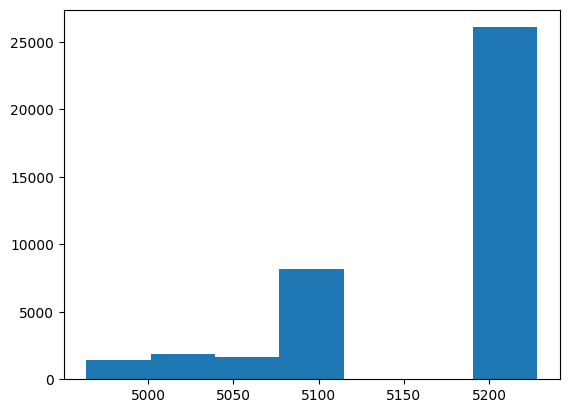

In [158]:
bins = create_bins(data, columns= ['nr.employed'])

bins

In [159]:
## This function helps to find the any new numbers belong to which bin
def find_bin_number(num, bins):
       
    
    if bins[0] <= num < bins[1]:
        return 0
    elif bins[1] <= num < bins[2]:
        return 1
    elif bins[2] <= num < bins[3]:
        return 2
    elif bins[3] <= num < bins[4]:
        return 3
    elif bins[4] <= num < bins[5]:
        return 4
    elif bins[5] <= num < bins[6]:
        return 5
    elif bins[6] <= num <= bins[7]:
        return 6

In [161]:
find_bin_number(5040, bins)

2

In [162]:
## To avoid errors in the future I'm doing Equal_width discritization
## Let's create a function to do equal_width_binning

In [60]:
def equal_width_binning(data, columns, number_of_bins=6):
    
    temp_df = data
    
    for col in columns:
        n, bins, patches = plt.hist(temp_df[col], bins = number_of_bins + 1)
        
        for bin_ in range(len(bins)-1):
            temp_df[col] = np.where(temp_df[col].between(bins[bin_],bins[bin_ + 1]), int(bin_), temp_df[col])
            
    temp_df[columns] = temp_df[columns].apply(np.int64)
    return temp_df

In [28]:
# applying equal_width_binning on emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m and nr.employed colums

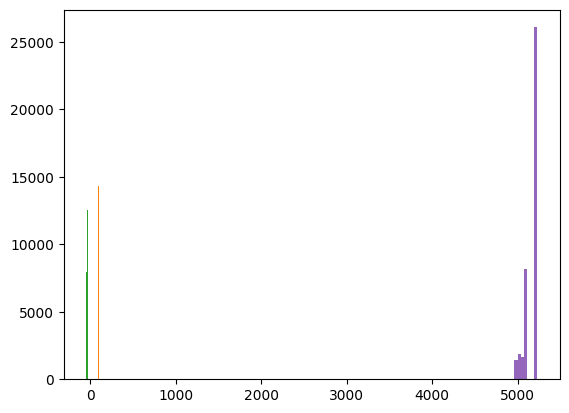

In [29]:
col = ['emp.var.rate','cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed']

df_after_binning = equal_width_binning(data, columns= col)

array([2.        , 2.57142857, 3.14285714, 3.71428571, 4.28571429,
       4.85714286, 5.42857143, 6.        ])

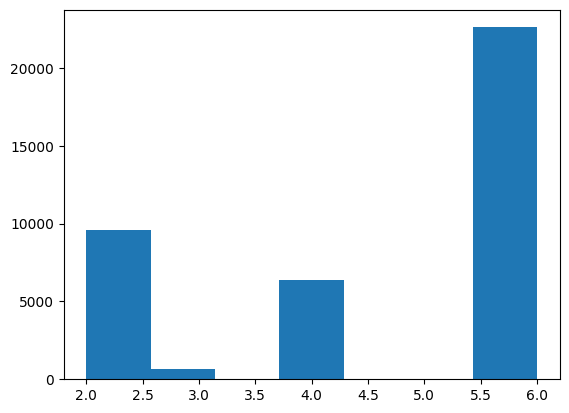

In [32]:
n, bins, patches = plt.hist(data['emp.var.rate'], bins = 7)

bins

In [30]:
df_after_binning['emp.var.rate'].value_counts()

6    22607
2     9592
4     6350
3      631
Name: emp.var.rate, dtype: int64

### Categorical Encoding

In [17]:
df_after_binning.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,other,married,basic.4y,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no


In [18]:
# creating df1 as a copy of df_after_binning

df1 = df_after_binning

df1.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,other,married,basic.4y,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,0,nonexistent,6,4,4,6,6,no


In [19]:
## creating a column_transformer to apply categorical encoding

col_transformer = ColumnTransformer([
    
    ('ordinal_encoder', OrdinalEncoder(
        
         categories=[['other','basic.4y','basic.6y','basic.9y','high.school','university.degree','professional.course'],
                     ['1', '2', '3', '4','more_than_4'],
                     ['0','1','more_than_1']
                    ], 
         dtype= np.int64 ),
         ['education','campaign','previous']),
    
    ('one_hot_encoder', OneHotEncoder(
        
        categories='auto',
        drop = 'first'), 
        ['job','marital','housing','loan','contact','month','day_of_week','poutcome']),
    
    ],remainder='passthrough')

In [20]:
# Lets fit_transform df1 data
# Output will be an array.

transformed_data = col_transformer.fit_transform(df1)

transformed_data

array([[1, 0, 0, ..., 6, 6, 'no'],
       [4, 0, 0, ..., 6, 6, 'no'],
       [4, 0, 0, ..., 6, 6, 'no'],
       ...,
       [5, 1, 0, ..., 0, 0, 'no'],
       [6, 0, 0, ..., 0, 0, 'yes'],
       [6, 2, 1, ..., 0, 0, 'no']], dtype=object)

In [21]:
#Lets see first row

transformed_data[0]

array([1, 0, 0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0,
       0.0, 56, 6, 4, 4, 6, 6, 'no'], dtype=object)

In [22]:
# Show 35 columns after dropping 1 column to avoid dumy variable trap

transformed_data.shape

(39180, 35)

## Outlier handling

#### Outliers are only present in age column.

In [23]:
data['age'].describe()

count    39180.000000
mean        40.120827
std         10.472185
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64

In [24]:
## Lets make a function to visualize the change in distribution and % of records getting dropped for each percentile value.

def outlier_handler(data, column, percentile = 0.95):
    
    temp = data.query(f"{column} < {column}.quantile({percentile})")
    
    precentage_of_data_dropped = (data.shape[0] - temp.shape[0]) / data.shape[0] * 100
    
    print("Percentage of data dropped:  " + str(np.round(precentage_of_data_dropped, 1)) + " %")
    
    sns.kdeplot(temp['age'])
    
    plt.show()

Percentage of data dropped:  5.6 %


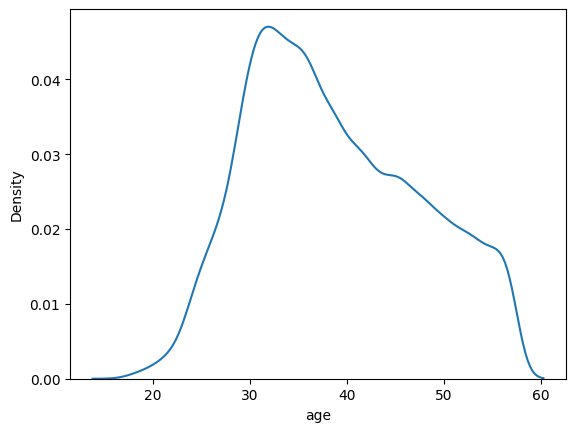

In [25]:
outlier_handler(data , 'age', percentile = 0.95)

Percentage of data dropped:  2.1 %


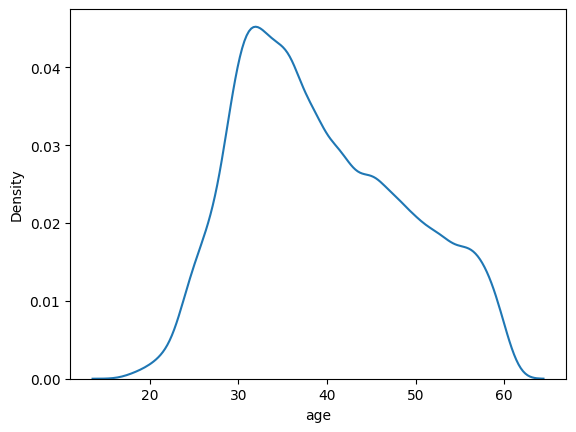

In [26]:
outlier_handler(data, 'age', percentile=.98)

Percentage of data dropped:  1.0 %


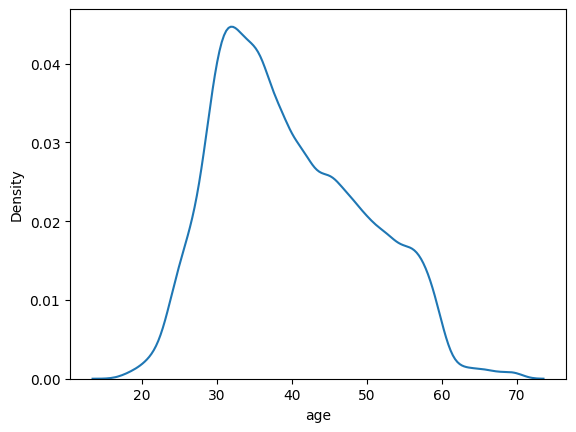

In [27]:
outlier_handler(data, 'age', percentile=.99)

- 95 percentile looks fine so proceeding with 95th percentile.

In [28]:
## Let's value_couts of see this outlier data

In [29]:
outlier_data = data.query(f'age > age.quantile(0.95)')

In [30]:
outlier_data['y'].value_counts()

no     1087
yes     534
Name: y, dtype: int64

<AxesSubplot:xlabel='y', ylabel='count'>

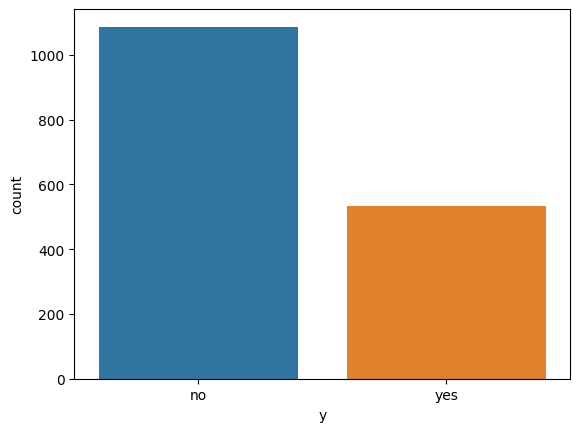

In [31]:
sns.countplot(x = outlier_data['y'])

- This show we will loose `541 records` of class `yes` if we drop the outliers from the data
- Since we are already dealing with a Imbalanced dataset, So we need to treat this outliers without dropping it.

In [32]:
## Making all values in age column as Nan which is above 95th percentile
data.loc[data['age'] > data['age'].quantile(0.95), 'age'] = np.nan

In [33]:
# Now we have 1655 Nan in age column

data.isnull().sum()

age               1621
job                  0
marital              0
education            0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [34]:
## For experiments we are keeping a taking a copy of the dataframe

mean_df = data.copy()

In [35]:
mean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39180 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37559 non-null  float64
 1   job             39180 non-null  object 
 2   marital         39180 non-null  object 
 3   education       39180 non-null  object 
 4   housing         39180 non-null  object 
 5   loan            39180 non-null  object 
 6   contact         39180 non-null  object 
 7   month           39180 non-null  object 
 8   day_of_week     39180 non-null  object 
 9   campaign        39180 non-null  object 
 10  previous        39180 non-null  object 
 11  poutcome        39180 non-null  object 
 12  emp.var.rate    39180 non-null  int64  
 13  cons.price.idx  39180 non-null  int64  
 14  cons.conf.idx   39180 non-null  int64  
 15  euribor3m       39180 non-null  int64  
 16  nr.employed     39180 non-null  int64  
 17  y               39180 non-null 

In [36]:
## trying to to impute Mean of the age column and visualize the distribution

mean_df.loc[mean_df['age'].isnull() == True] = mean_df['age'].mean()

<AxesSubplot:xlabel='age', ylabel='Count'>

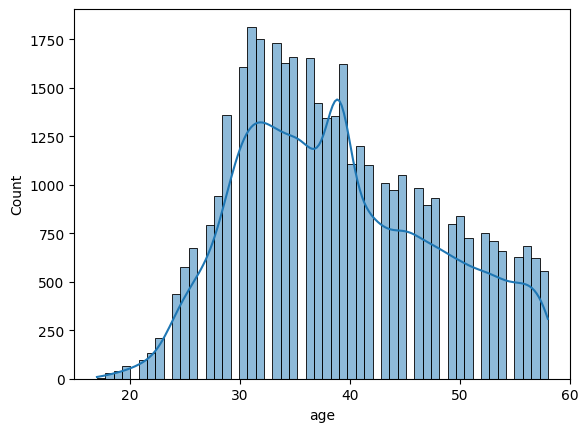

In [37]:
sns.histplot(mean_df['age'], kde = True)

<AxesSubplot:xlabel='age', ylabel='Count'>

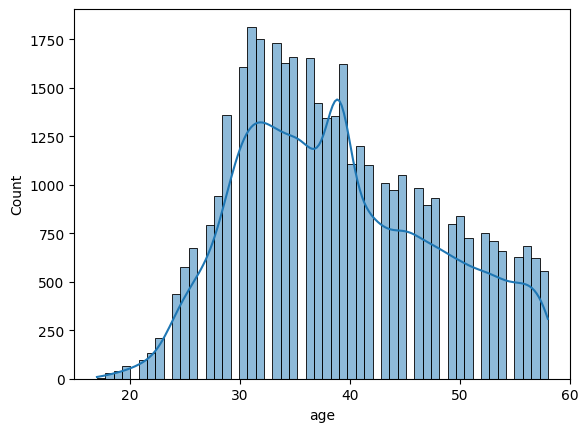

In [38]:
median_df = data.copy()

median_df.loc[median_df['age'].isnull() == True] = median_df['age'].mean()

sns.histplot(median_df['age'], kde = True)

In [39]:
## Let's use KNNImputer 
## To use KNNImputer every column has to be numerical, so we are using 'ransformed_data' array. Since data have categorical values so we cannot use that.

In [40]:
## Lets create dataset for outlier and dropping 'y' value i.e. last column for KNNImputer

X_df_for_outlier = transformed_data[: , : -1]

X_df_for_outlier

array([[1, 0, 0, ..., 4, 6, 6],
       [4, 0, 0, ..., 4, 6, 6],
       [4, 0, 0, ..., 4, 6, 6],
       ...,
       [5, 1, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [6, 2, 1, ..., 0, 0, 0]], dtype=object)

In [41]:
imputer = KNNImputer(n_neighbors=3)

X_after_imputation = imputer.fit_transform(X_df_for_outlier)

X_after_imputation

array([[1., 0., 0., ..., 4., 6., 6.],
       [4., 0., 0., ..., 4., 6., 6.],
       [4., 0., 0., ..., 4., 6., 6.],
       ...,
       [5., 1., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [6., 2., 1., ..., 0., 0., 0.]])

In [42]:
X_after_imputation.shape

(39180, 34)

In [43]:
Y_df_for_outlier = transformed_data[: , -1]

In [44]:
y_imputer = LabelEncoder()

In [45]:
Y_after_imputation = y_imputer.fit_transform(Y_df_for_outlier)

In [46]:
Y_after_imputation

array([0, 0, 0, ..., 0, 1, 0])

In [47]:
Y_after_imputation.shape

(39180,)

<AxesSubplot:ylabel='Count'>

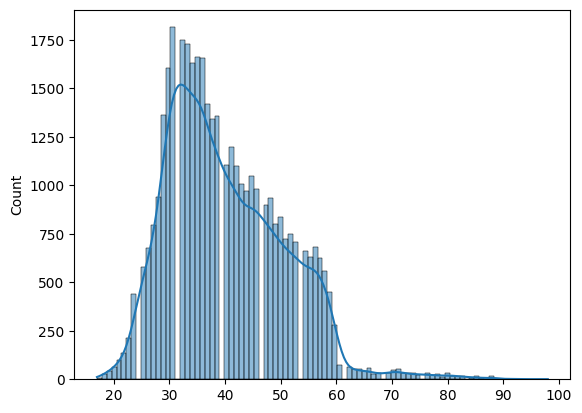

In [48]:
## KNNImputation of age column

sns.histplot(X_after_imputation[:, -6], kde=True)

## Skewness handling of age column

In [49]:
df_for_skewness = X_after_imputation

# Let's see the postition of age in array
df_for_skewness[0]

array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0., 56.,  6.,  4.,  4.,  6.,  6.])

<AxesSubplot:ylabel='Count'>

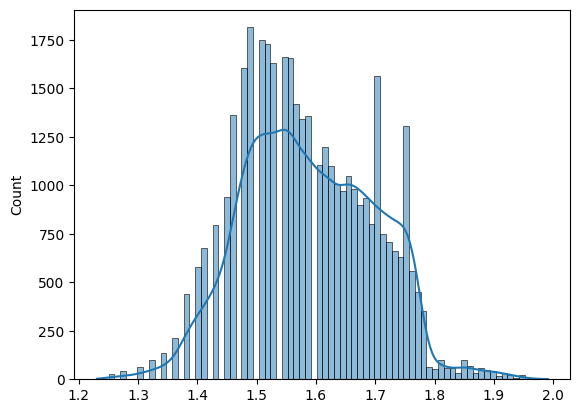

In [50]:
# From above array we can see the age is at -6 index
# Lets apply log10 transformation on age and see the distribution

sns.histplot(np.log10(df_for_skewness[:, -6]), kde= True)

<AxesSubplot:ylabel='Count'>

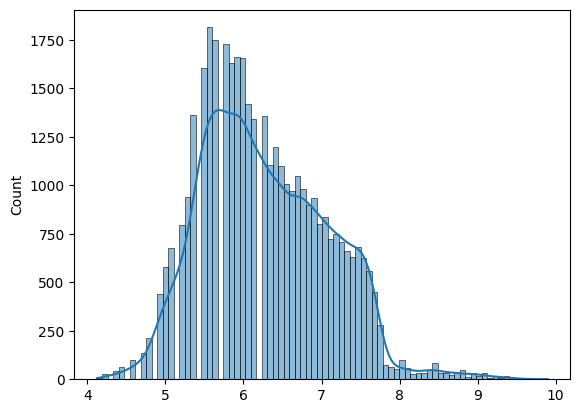

In [51]:
# Lets apply square root transformation on age and see the distribution


sns.histplot(np.sqrt(df_for_skewness[:, -6]), kde= True)

<AxesSubplot:ylabel='Count'>

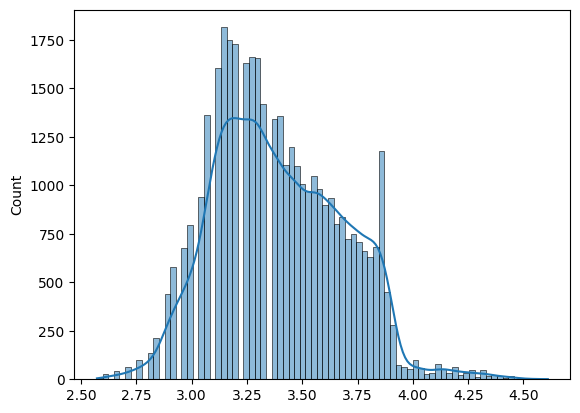

In [52]:
# Lets apply cube root transformation on age and see the distribution
sns.histplot(np.cbrt(df_for_skewness[:, -6]), kde= True)

<AxesSubplot:ylabel='Count'>

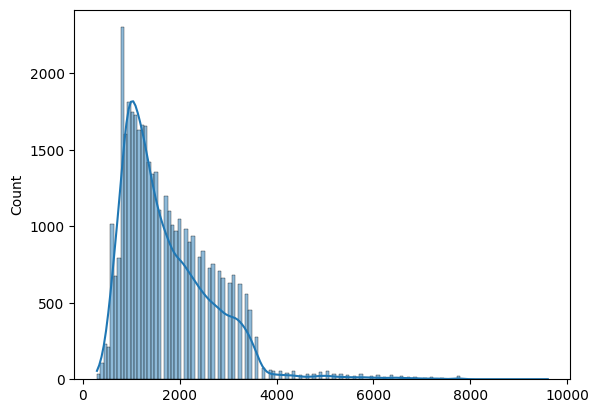

In [53]:
# Lets apply square transformation on age and see the distribution
sns.histplot(np.square(df_for_skewness[:, -6]), kde= True)

In [54]:
# Lets apply yeo_johnson transformation on age and see the distribution

column_scaling_transformer = ColumnTransformer(
    
                             transformers= [('yeo_johson', PowerTransformer(method='yeo-johnson'), [-6])],
                                remainder='passthrough')

In [55]:
df_yeo_johnson = column_scaling_transformer.fit_transform(df_for_skewness)

df_yeo_johnson[0]

array([1.4160728, 1.       , 0.       , 0.       , 0.       , 0.       ,
       1.       , 0.       , 0.       , 1.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 1.       , 0.       ,
       0.       , 0.       , 1.       , 0.       , 0.       , 1.       ,
       0.       , 0.       , 0.       , 1.       , 0.       , 6.       ,
       4.       , 4.       , 6.       , 6.       ])

<AxesSubplot:ylabel='Count'>

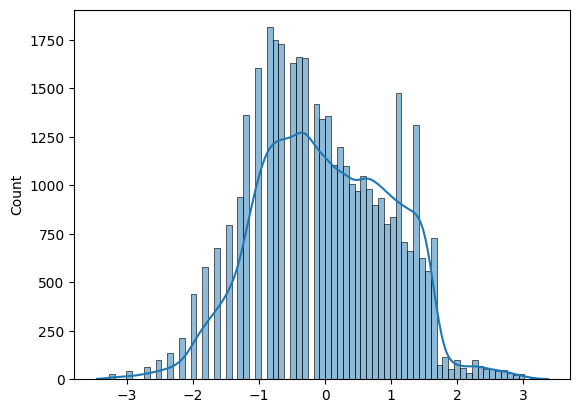

In [56]:
sns.histplot(df_yeo_johnson[:,0], kde=True)

In [57]:
## This distributions after yeo_johnson transformation looks like a normal distribution, 
## scaling is done internally by yeo_johson transformer
## So keeping this data as final data for training the model

## Final Data for training

In [58]:
Final_X = pd.DataFrame(df_yeo_johnson)

Final_X.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
13156,-0.751087,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,6.0,4.0,2.0,6.0,6.0
29281,0.328641,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0
34500,-0.626376,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,4.0,2.0,2.0,0.0,2.0
17746,-1.014739,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,6.0,4.0,2.0,6.0,6.0
2255,0.508298,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
8043,-0.880433,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,6.0,6.0,2.0,6.0,6.0
10505,1.141310,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,6.0,6.0,2.0,6.0,6.0
2233,1.544887,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
19917,0.678589,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,6.0,3.0,4.0,6.0,6.0
5937,-1.154366,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0


In [59]:
Final_Y =  pd.Series(Y_after_imputation)

Final_Y.sample(10)

23001    0
30243    0
36182    0
23311    1
13253    0
13552    0
27455    0
30914    0
33286    0
28832    1
dtype: int32

## Looking for Clusters in Dataset

#### Checking any possibilty of Clusters in the dataset other that target column cluster

In [60]:
## I'm fitting  multiple KMeans on the dataset with different value of n_clusters
wcss = {}

for k in range(1,15):
    KM = KMeans(n_clusters=k, init='k-means++', max_iter= 1000)
    KM.fit(Final_X)
    wcss[k] = KM.inertia_

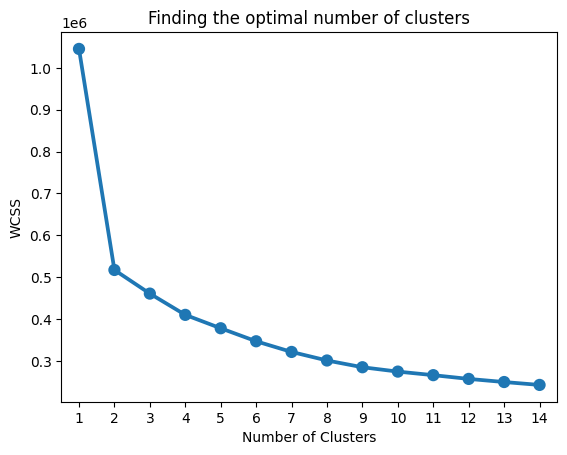

In [61]:
## Plotting Elbow plot to find optimum value of n_clusters

sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title("Finding the optimal number of clusters")
plt.show()

## Plot shows 2 clusters are possible

In [62]:
## Lets cross verify with KneeLocator method

KN = KneeLocator(x = list(wcss.keys()),  y= list(wcss.values()), curve='convex', direction='decreasing')

KN.knee

2

In [63]:
# Creating the final KMeans model with clusters = 2

KN_final = KMeans(n_clusters=2)

KN_final.fit(Final_X)

KN_final.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [64]:
# Combining the predictions to Final_X dataframe

Final_X['cluster'] = KN_final.labels_

In [65]:
# Lets a sample of dataset

Final_X.sample(20)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,cluster
4884,-0.168355,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0
4099,0.994394,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0
10422,-0.751087,6.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,6.0,6.0,2.0,6.0,6.0,0
25462,0.234999,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,4.0,2.0,2.0,6.0,6.0,0
33282,-1.451219,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,1
33701,-0.506004,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,1
2446,1.068702,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0
3476,0.760495,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0
9911,-0.506004,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,6.0,6.0,2.0,6.0,6.0,0
14956,-1.451219,6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,6.0,4.0,2.0,6.0,6.0,0


In [66]:
## Lets verify the KMeans are finding the groups based on target column or not 
## i.e. one cluster to 0 and other cluster as 1 like same as target column

In [67]:
## lets take from above sample of Final_X with cluster column added, taking index 31492 which KMeans predicts as cluster=1
## Now lets see the corresponding 'y' value from Final_Y 

Final_Y.loc[Final_Y.index == 31492]  #but result which shows 0

31492    0
dtype: int32

In [68]:
## Now lets take another Index with cluster = 1


Final_Y.loc[Final_Y.index == 28945]

## For this y value shows 1, which means the data itself have 2 clusters independent of target column value.

28945    1
dtype: int32

In [69]:
## Now lets take another Index with cluster = 0, 


Final_Y.loc[Final_Y.index == 5444]  # here results shows target column as 0
## which means we can once again confirm that the data itself have 2 clusters independent of target column value.

5444    0
dtype: int32

### Again we need to merge Final_X and Final_Y to split the data with respect to clusters

In [70]:
Final_X['target'] = Final_Y

Final_X.sample(20)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,cluster,target
22948,-0.062877,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,4.0,2.0,2.0,6.0,6.0,0,0
34024,-0.277228,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,1.0,1.0,0.0,3.0,1,0
29958,0.234999,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,1,0
16186,-0.626376,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,2.0,6.0,6.0,0,0
8025,-0.880433,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,6.0,6.0,2.0,6.0,6.0,0,1
27095,0.234999,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,1,0
36365,-0.062877,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,4.0,0.0,6.0,0.0,1.0,1,1
25049,-0.506004,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,4.0,2.0,2.0,6.0,6.0,0,1
22598,0.234999,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,3.0,4.0,6.0,6.0,0,0
35136,1.068702,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,4.0,0.0,5.0,0.0,2.0,1,0


In [71]:
## creating dataframes for both clusters seperatly

df_cluster0 = Final_X.loc[Final_X['cluster']== 0]

df_cluster1 = Final_X.loc[Final_X['cluster']== 1]

In [72]:
## Lets see the shape of both the dataframe

print(df_cluster0.shape)

print(df_cluster1.shape)

(26101, 36)
(13079, 36)


In [73]:
print(f"Percentage of data in cluster 0 is {np.round(26101/(26101+13079) * 100, 1)}%")

print(f"Percentage of data in cluster 1 is {np.round(13079/(26101+13079) * 100, 1)}%")

Percentage of data in cluster 0 is 66.6%
Percentage of data in cluster 1 is 33.4%


##### Note: Cluster 0 have more data compared to Cluster 1

In [74]:
## Lets see what is the count of target in both the cluster

In [75]:
df_cluster0['target'].value_counts()

0    24772
1     1329
Name: target, dtype: int64

### Dataset created for Cluster 0

<AxesSubplot:xlabel='target', ylabel='count'>

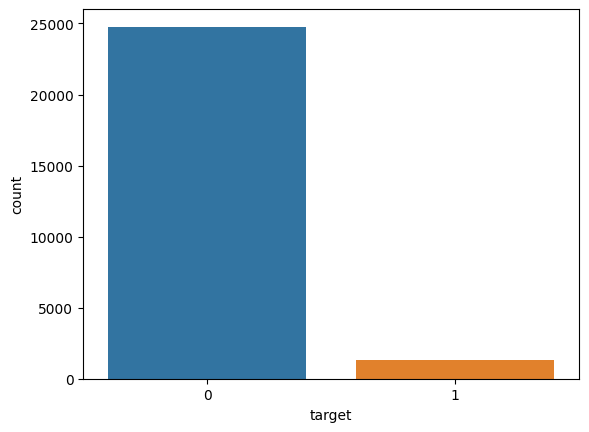

In [76]:
sns.countplot(data = df_cluster0, x = 'target')

In [77]:
df_cluster1['target'].value_counts()

0    9817
1    3262
Name: target, dtype: int64

### Dataset created for Cluster 1

<AxesSubplot:xlabel='target', ylabel='count'>

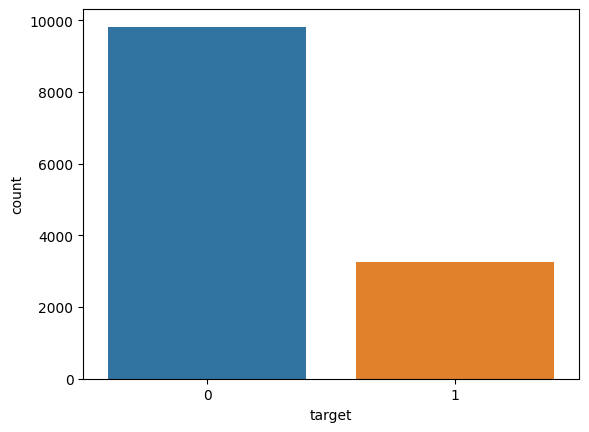

In [78]:
sns.countplot(data = df_cluster1, x = 'target')

##### Note: The Cluster 0 have highly Imbalanced data, Cluster 1 have comparitively less Imbalanced data

### Final data set is ready for both cluster 0 and cluster 1

In [79]:
df_cluster0.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,cluster,target
0,1.416073,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
1,1.481148,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
2,-0.168355,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
3,0.138632,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
4,1.416073,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0


In [80]:
df_cluster0.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,cluster,target
0,1.416073,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
1,1.481148,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
2,-0.168355,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
3,0.138632,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0
4,1.416073,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0,0,0


## Model Training

In [81]:
## Creating a copy of data

In [82]:
Cluster0 = df_cluster0
Cluster1 = df_cluster1

In [83]:
Cluster0.shape

(26101, 36)

In [84]:
Cluster1.shape

(13079, 36)

#### Seperating X and Y for both Cluster data

In [85]:
X_Cluster0  = Cluster0.drop(['cluster', 'target'], axis='columns')

Y_Cluster0 = Cluster0['target']

In [86]:
X_Cluster0.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,1.416073,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
1,1.481148,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
2,-0.168355,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
3,0.138632,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0
4,1.416073,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,6.0,4.0,4.0,6.0,6.0


In [87]:
Y_Cluster0.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [88]:
X_Cluster1  = Cluster1.drop(['cluster', 'target'], axis='columns')

Y_Cluster1 = Cluster1['target']

In [89]:
X_Cluster1.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
26101,0.508298,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,3.0,5.0
26102,-1.609385,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0
26103,-0.062877,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0
26104,-1.609385,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0
26105,-1.609385,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,3.0


In [90]:
Y_Cluster1.head()

26101    1
26102    1
26103    1
26104    0
26105    0
Name: target, dtype: int32

In [91]:
## Creating Traing and test datafor Cluster 0

X0_train, X0_test, Y0_train, Y0_test = train_test_split(X_Cluster0, Y_Cluster0, test_size = .20,random_state=369)

In [92]:
## Creating Traing and test data Cluster 1

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_Cluster1, Y_Cluster1, test_size = .20,random_state=369)

In [93]:
def func(model,x_train, y_train, x_test, y_test, cv = None, params = None, scoring = 'recall'):
    
    grid = GridSearchCV(estimator=model,
                        param_grid= params,
                        scoring=scoring)
    
    grid_result = grid.fit(x_train, y_train)
    
    LR_Final_c1 = LogisticRegression(**grid_result_c1.best_params_)
    
    LR_Final_c1.fit(X1_train, Y1_train)
    
    pred = LR_Final_c1.predict(X1_test)
    
    print("Accuracy = " , accuracy_score(y_test, pred))
    print("Precision = " ,precision_score(y_test, pred))
    print("Recall = " ,recall_score(y_test, pred))
    print("F1 Score = " ,f1_score(y_test, pred))
    
    return grid_result.best_params_, grid_result_c1.best_score_, 

#### Model creation

In [94]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

In [17]:
lr= LogisticRegression()

In [28]:
str(lr)

'LogisticRegression()'

### Lets try with multiple ML algorithms with bdefault hyperparameters

In [96]:
## Creating a Stratified K-Fold object for cross validation

cv = StratifiedKFold(n_splits=10, shuffle= True, random_state=369)

In [97]:
LR = LogisticRegression()

In [98]:
## Lets create multiple models using cross_val_score and let's look the accuracy

LR_accuacy_score = cross_val_score(LR, X0_train, Y0_train, cv= cv, scoring='accuracy')

LR_accuacy_score 

array([0.94923372, 0.94971264, 0.95019157, 0.94923372, 0.94971264,
       0.94827586, 0.94875479, 0.94875479, 0.9506705 , 0.94923372])

In [99]:
## Since we are dealin with Imbalanced dataset so accuracy is not a good metric
## So we can use Recall, Precision, F1-score.
## Keeping Recall as scoring parameter (Since we need to less False Negative)

LR_recall_score = cross_val_score(LR, X0_train, Y0_train, cv= cv, scoring='recall')

LR_recall_score 

array([0.00934579, 0.03738318, 0.04672897, 0.02803738, 0.05607477,
       0.01869159, 0.02803738, 0.01869159, 0.04672897, 0.02777778])

In [100]:
## Lets see the maximum recall we got
LR_recall_score.max()

0.056074766355140186

In [101]:
## Looks like very small variance in the score

LR_recall_score.std()

0.013994657486880318

In [102]:
RF = RandomForestClassifier()

In [103]:
RF_recall_score = cross_val_score(RF, X0_train, Y0_train, cv=cv, scoring='recall')

RF_recall_score

array([0.01869159, 0.03738318, 0.01869159, 0.02803738, 0.04672897,
       0.01869159, 0.02803738, 0.01869159, 0.03738318, 0.03703704])

In [104]:
RF_recall_score.max()

0.04672897196261682

In [105]:
RF_recall_score.std()

0.009727965465113494

In [4]:
XGBoost = XGBClassifier()

In [107]:
XGB_recall_score = cross_val_score(XGBoost, X0_train, Y0_train, cv=cv, scoring='recall')

XGB_recall_score

array([0.01869159, 0.02803738, 0.02803738, 0.02803738, 0.03738318,
       0.00934579, 0.02803738, 0.01869159, 0.01869159, 0.02777778])

In [108]:
XGB_recall_score.max()

0.037383177570093455

In [109]:
XGB_recall_score.std()

0.007464050285269911

In [110]:
SVM = SVC()

In [111]:
SVM_recall_score = cross_val_score(SVM, X0_train, Y0_train, cv=cv, scoring='recall')

SVM_recall_score

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [112]:
SVM_recall_score.max()

0.0

In [113]:
SVM_recall_score.std()

0.0

In [114]:
DT = DecisionTreeClassifier()

In [115]:
Dt_recall_score = cross_val_score(DT, X0_train, Y0_train, cv=cv, scoring='recall')

Dt_recall_score

array([0.09345794, 0.05607477, 0.10280374, 0.08411215, 0.11214953,
       0.09345794, 0.08411215, 0.04672897, 0.08411215, 0.12962963])

In [116]:
Dt_recall_score.max()

0.12962962962962962

In [117]:
Dt_recall_score.std()

0.023148243579219893

In [3]:
XGB_RF = XGBRFClassifier()

In [119]:
XGB_RF_recall_score = cross_val_score(XGB_RF, X0_train, Y0_train, cv=cv, scoring='recall')

XGB_RF_recall_score

array([0.01869159, 0.02803738, 0.03738318, 0.02803738, 0.05607477,
       0.01869159, 0.02803738, 0.01869159, 0.02803738, 0.02777778])

In [120]:
XGB_RF_recall_score.max()

0.056074766355140186

In [121]:
XGB_RF_recall_score.std()

0.010617353053739965

##### Note: All base models not having an acceptable recall value

### Hyper-Parameter tuning of Logistic Regressor

### Cluster - 0

In [122]:
## Creating a function which can display multiple scores of a model

def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))

In [124]:
## Creating a function which can do GridsearchCV with cross validation 
## Function will return best_parameter for a given algorithm and multiple score of the best model found

def best_param_finder(model,x_train, y_train, x_test, y_test, cv = None, params = None, scoring = 'recall'):
    
    ## Creating Gridsearch CV object
    grid = GridSearchCV(estimator = model,
                        param_grid = params,
                        scoring = scoring)
    
    #Fitting n the estimator provided
    grid_result = grid.fit(x_train, y_train)
    
    ## Creating a final model from best_params
    Final_model = LogisticRegression(**grid_result.best_params_)
    
    # Fitting the data on final model
    Final_model.fit(x_train, y_train)
    
    # Predictions are made on test data
    pred = Final_model.predict(x_test)
    
    # printing the following matrices of final model
    print("Accuracy of best model = " , accuracy_score(y_test, pred))
    print("Precision of best model = " ,precision_score(y_test, pred))
    print("Recall of best model = " ,recall_score(y_test, pred))
    print("F1 Score of best model = " ,f1_score(y_test, pred))
    
    return grid_result.best_params_


#### Logistic Regression

In [125]:
## Creating a Stratified K-Fold object for cross validation

cv = StratifiedKFold(n_splits=5, shuffle= True, random_state=369)

In [126]:
## Creating multiple weights to handle Imbalance of data

weights  = np.linspace(0.05, 0.95, 3)

In [127]:
## Logistic regressor hyperparameter

params = {'penalty': ['l2', 'elasticnet'],
          'C' : np.linspace(1.00, 2.99, 3),   
          'class_weight': [{0: x, 1:1.0 - x} for x in weights]} 

In [128]:
## lets try to find best params

LR = LogisticRegression()

result = best_param_finder(LR, X0_train, Y0_train, X0_test, Y0_test, cv=cv, params=params, scoring='recall')

Accuracy of best model =  0.5259528825895422
Precision of best model =  0.06203081785855393
Recall of best model =  0.6085271317829457
F1 Score of best model =  0.11258515596988168


In [136]:
## Lets create the final model from best_params founded

LR_Final_0 = LogisticRegression(**result)

LR_Final_0.fit(X0_train, Y0_train)

pred = LR_Final_0.predict(X0_test)

generate_model_report(Y0_test, pred)

Accuracy =  0.5259528825895422
Precision =  0.06203081785855393
Recall =  0.6085271317829457
F1 Score =  0.11258515596988168


<AxesSubplot:>

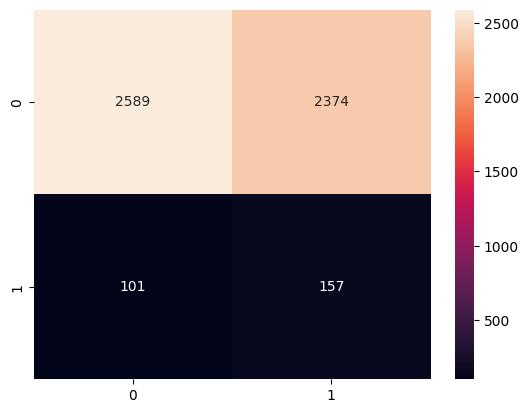

In [137]:
sns.heatmap(confusion_matrix(Y0_test,pred), annot=True, fmt='.100g')

### Precision- Recall Curve (Cluster 0)

In [138]:
Y0_test.value_counts()

0    4963
1     258
Name: target, dtype: int64

In [139]:
np.round(656/len(Y0_test), 2)

0.13

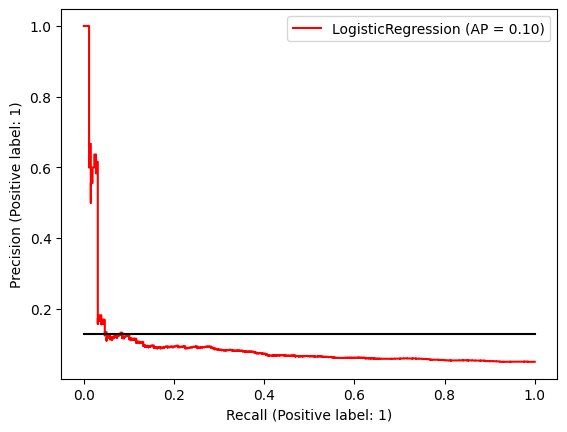

In [141]:
plot_precision_recall_curve(LR_Final_0,X0_test, Y0_test, c='r')
plt.plot([0,1], [0.13,0.13], c='k')  ## Showing base line classifier, model below this is worse
plt.legend(loc='best')

### Cluster - 1

#### Logistic Regression

In [142]:
## Creating a Stratified K-Fold object for cross validation

cv = StratifiedKFold(n_splits=5, shuffle= True, random_state=369)     

In [143]:
## Creating multiple weights to handle Imbalance of data

weights  = np.linspace(0.05, 0.95, 10)

In [144]:
## Logistic regressor hyperparameter

params = {'penalty': ['l2', 'elasticnet'],
          'C' : np.linspace(1.00, 2.99, 10),   
          'class_weight': [{0: x, 1:1.0 - x} for x in weights]} 

In [145]:
LR = LogisticRegression()

result = best_param_finder(LR, X1_train, Y1_train, X1_test, Y1_test, cv=cv, params=params, scoring='recall')

Accuracy of best model =  0.28325688073394495
Precision of best model =  0.25842251288149026
Recall of best model =  0.9939024390243902
F1 Score of best model =  0.41019188424032704


In [146]:
LR_Final_1 = LogisticRegression(**result)

In [147]:
LR_Final_1.fit(X1_train, Y1_train)

LogisticRegression(class_weight={0: 0.05, 1: 0.95})

In [148]:
pred = LR_Final_1.predict(X1_test)

In [149]:
generate_model_report(Y1_test, pred)

Accuracy =  0.28325688073394495
Precision =  0.25842251288149026
Recall =  0.9939024390243902
F1 Score =  0.41019188424032704


<AxesSubplot:>

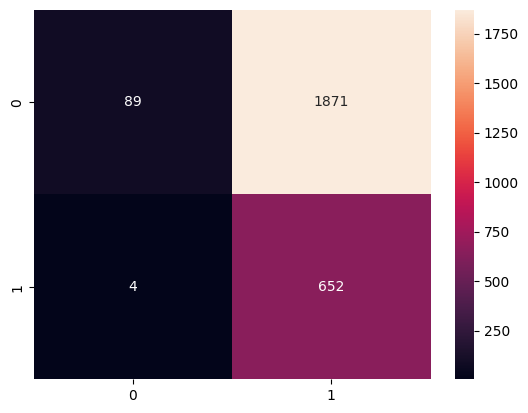

In [150]:
sns.heatmap(confusion_matrix(Y1_test,pred), annot=True, fmt='.100g')

### Precision- Recall Curve (Cluster 1)

In [151]:
Y1_test.value_counts()

0    1960
1     656
Name: target, dtype: int64

In [152]:
np.round(258/len(Y1_test), 2)

0.1

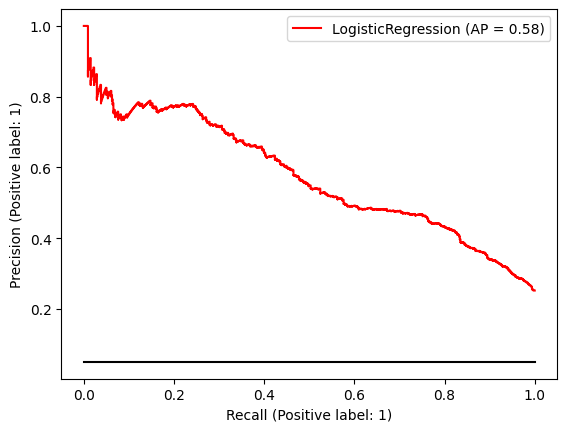

In [153]:
plot_precision_recall_curve(LR_Final_1,X1_test, Y1_test, c='r')
plt.plot([0,1], [0.05,0.05], c='k')  ## Showing base line classifier, model below this is worse
plt.legend(loc='best')